---
title: 02 - mouse integration
author: Martin Proks
date: 26-08-2023
---

In [8]:
!which pip

~/projects/data/Brickman/conda/envs/scvi-1.0.0/bin/pip


In [9]:
import scvi
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt


from rich import print
from scib_metrics.benchmark import Benchmarker
from scvi.model.utils import mde


import warnings
from lightning_fabric.plugins.environments.slurm import PossibleUserWarning
warnings.simplefilter(action='ignore', category=PossibleUserWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

scvi.settings.seed = 42

[rank: 0] Global seed set to 42


In [10]:
sc.set_figure_params(figsize=(10, 6))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [11]:
adata = sc.read("../data/processed/01_mouse_reprocessed.h5ad")
adata

AnnData object with n_obs × n_vars = 2004 × 34346
    obs: 'batch', 'experiment', 'technology', 'ct', 'ct_orig', 'stage', 'timepoint', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts'
    var: 'gene_ids', 'gene_symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [12]:
# sc.pp.highly_variable_genes(
#     adata,
#     flavor="seurat_v3",
#     n_top_genes=3_000,
#     layer="counts",
#     batch_key="batch",
#     subset=True,
# )

In [13]:
adata.uns['log1p']["base"] = None
sc.pp.highly_variable_genes(
    adata,
    flavor="cell_ranger",
    n_top_genes=3_000,
    # batch_key="batch",
    batch_key="experiment",
    subset=True,
)
adata.shape

(2004, 3000)

## 1. SCVI

In [14]:
import jax
jax.devices()

[gpu(id=0), gpu(id=1), gpu(id=2), gpu(id=3)]

In [15]:
adata.obs['batch_og'] = adata.obs['batch']
adata.obs['batch'] = adata.obs.experiment.cat.codes.astype(str) + "_" + adata.obs.batch.cat.codes.astype(str)
# adata.obs['batch_og'] = adata.obs['batch']
# adata.obs['batch'] = adata.obs.experiment.cat.codes.astype(str) + "_" + adata.obs.technology.cat.codes.astype(str)
# adata.obs['batch'] = adata.obs.batch.astype(str) + "_" + adata.obs.technology.cat.codes.astype(str)
# adata.obs['batch'] = adata.obs.technology.astype(str) + "_" + adata.obs.batch.str.split('_', expand=True).iloc[:, 1].astype(str)

In [16]:
scvi.model.SCVI.setup_anndata(
    adata, 
    layer="counts", 
    batch_key="batch",
    # batch_key="experiment|technology",
    # categorical_covariate_keys=["technology"]
)


vae = scvi.model.SCVI(adata, n_layers=2, gene_likelihood='nb')

# old settings
# vae = scvi.model.SCVI(adata, dropout_rate=0.01, n_layers=3, n_latent=10, gene_likelihood='nb') # 0.58
# other
# vae = scvi.model.SCVI(adata, dropout_rate=0.005, n_layers=2, n_latent=20, gene_likelihood='nb')
# vae = scvi.model.SCVI(adata, gene_likelihood='nb', dropout_rate=0.01, n_layers=3) # 0.57
# from tunning
# vae = scvi.model.SCVI(adata, dropout_rate=0.002, n_layers=3, gene_likelihood='zinb')
# vae = scvi.model.SCVI(adata, dropout_rate=0.005, n_layers=2, gene_likelihood='zinb')
vae

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [17]:
vae.train(use_gpu=1, max_epochs=400, early_stopping=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 386/400:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 386/400 [00:51<00:01,  7.46it/s, v_num=1, train_loss_step=4.71e+3, train_loss_epoch=4.95e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 5377.381. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

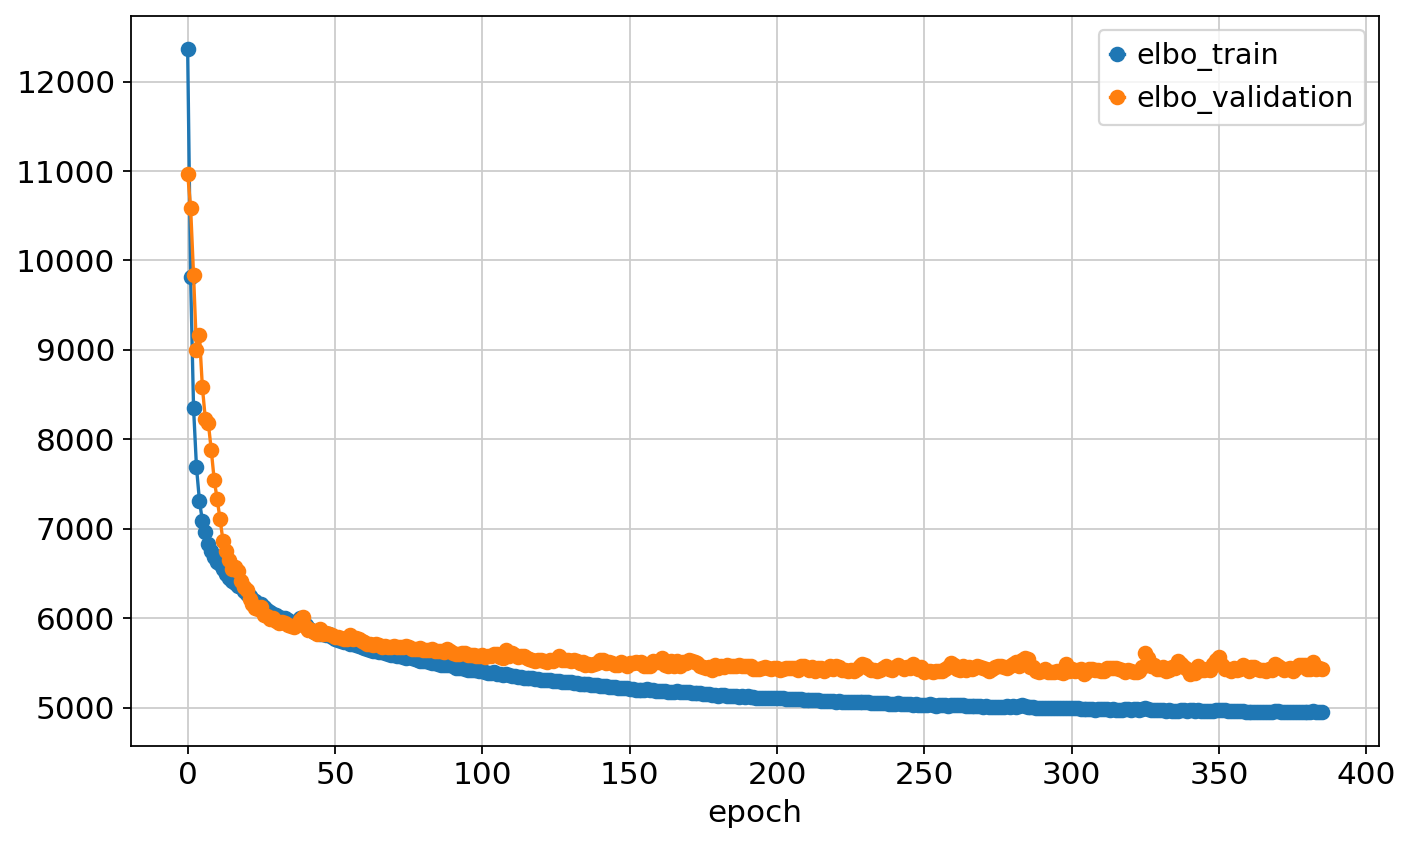

In [18]:
pd.concat([vae.history['elbo_train'], vae.history['elbo_validation']], axis=1).plot.line(marker='o')

In [19]:
# fig, ax = plt.subplots(1, 12, figsize=[25, 4])
# for idx, key in enumerate(vae.history.keys()):
#     vae.history[key].plot(title=key, ax=ax[idx])

In [20]:
adata.obsm["X_scVI"] = vae.get_latent_representation(adata)
adata.obsm["X_mde_scVI"] = mde(adata.obsm["X_scVI"])

adata.layers['scVI_normalized'] = vae.get_normalized_expression(return_numpy=True)

In [21]:
vae.save("../results/02_mouse_integration/scvi", overwrite=True, save_anndata=True)

## 2. SCANVI

In [22]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="ct",
    unlabeled_category="Unknown",
)
lvae

ScanVI Model with the following params: 
unlabeled_category: Unknown, n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb
Training status: Not Trained
Model's adata is minified?: False

In [23]:
max_epochs_scanvi = int(np.min([10, np.max([2, round(200 / 3.0)])]))
print(max_epochs_scanvi)

lvae.train(max_epochs=15)

10

INFO     Training for 15 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 15/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.30it/s, v_num=1, train_loss_step=4.93e+3, train_loss_epoch=5.19e+3]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.06it/s, v_num=1, train_loss_step=4.93e+3, train_loss_epoch=5.19e+3]


In [24]:
# fig, ax = plt.subplots(3, 3, figsize=[20, 14])
# for idx, key in enumerate(lvae.history.keys()):
#     lvae.history[key].plot(title=key, ax=ax[idx // 3 , idx % 3])

In [25]:
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)
adata.obsm["X_mde_scANVI"] = mde(adata.obsm["X_scANVI"])

adata.layers['scANVI_normalized'] = lvae.get_normalized_expression(return_numpy=True)

In [26]:
lvae.save("../results/02_mouse_integration/scanvi", overwrite=True, save_anndata=True)

## 3. scGEN

In [27]:
import scgen

In [28]:
scgen.SCGEN.setup_anndata(adata, batch_key="batch", labels_key="ct")

In [29]:
mscgen = scgen.SCGEN(adata)

In [30]:
mscgen.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=20,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 26/100:  26%|███████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 26/100 [00:10<00:30,  2.40it/s, v_num=1, train_loss_step=482, train_loss_epoch=372]
Monitored metric elbo_validation did not improve in the last 20 records. Best score: 1392.700. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

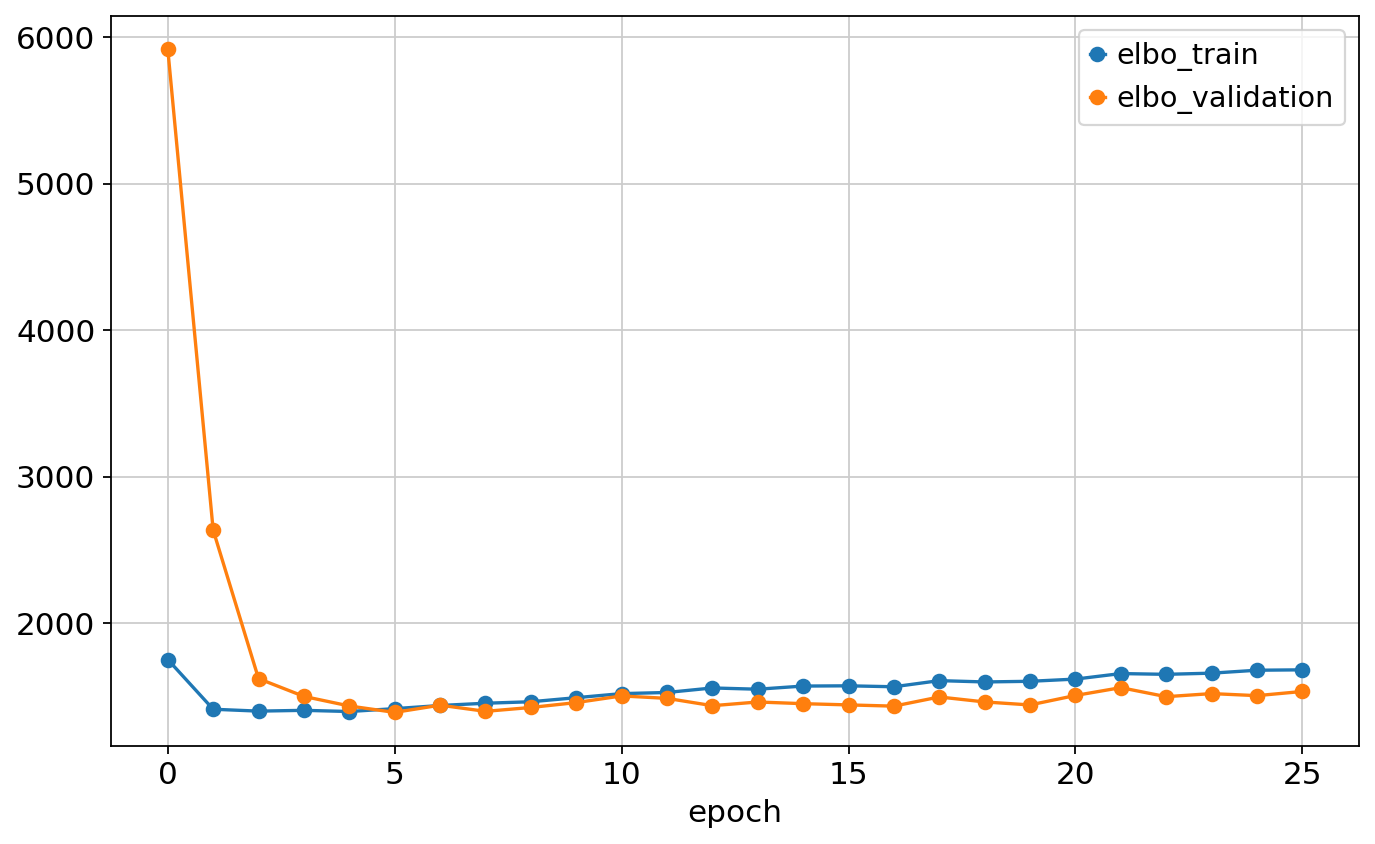

In [31]:
pd.concat([mscgen.history['elbo_train'], mscgen.history['elbo_validation']], axis=1).plot.line(marker='o')

In [32]:
adata.obsm["X_scgen"] = mscgen.batch_removal().obsm['corrected_latent']
adata.obsm["X_mde_scgen"] = mde(adata.obsm["X_scgen"])

adata.layers['scgen_decoded_expr'] = mscgen.get_decoded_expression()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [33]:
mscgen.save("../results/02_mouse_integration/scgen", overwrite=True, save_anndata=True)

## 4. Stats

Computing neighbors:   0%|                                                                                                                                                                                                                                                                                                                          | 0/4 [00:00<?, ?it/s]/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython'

INFO     E3.25-ICM consists of a single batch or is too small. Skip.                                               
INFO     E3.25-TE consists of a single batch or is too small. Skip.                                                
INFO     E3.5-EPI consists of a single batch or is too small. Skip.                                                
INFO     E3.5-PrE consists of a single batch or is too small. Skip.                                                
INFO     E3.75-ICM consists of a single batch or is too small. Skip.                                               
INFO     E4.5-TE consists of a single batch or is too small. Skip.                                                 



Metrics:   0%|                                                                                                                                                                                                                                                                                                                                     | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                                                                                                                                                          
Metrics:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         

INFO     E3.25-ICM consists of a single batch or is too small. Skip.                                               
INFO     E3.25-TE consists of a single batch or is too small. Skip.                                                
INFO     E3.5-EPI consists of a single batch or is too small. Skip.                                                
INFO     E3.5-PrE consists of a single batch or is too small. Skip.                                                
INFO     E3.75-ICM consists of a single batch or is too small. Skip.                                               
INFO     E4.5-TE consists of a single batch or is too small. Skip.                                                 



Metrics:   0%|                                                                                                                                                                                                                                                                                                                                     | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                                                                                                                                                          
Metrics:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         

INFO     E3.25-ICM consists of a single batch or is too small. Skip.                                               
INFO     E3.25-TE consists of a single batch or is too small. Skip.                                                
INFO     E3.5-EPI consists of a single batch or is too small. Skip.                                                
INFO     E3.5-PrE consists of a single batch or is too small. Skip.                                                
INFO     E3.75-ICM consists of a single batch or is too small. Skip.                                               
INFO     E4.5-TE consists of a single batch or is too small. Skip.                                                 



Metrics:   0%|                                                                                                                                                                                                                                                                                                                                     | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                                                                                                                                                          
Metrics:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         

INFO     E3.25-ICM consists of a single batch or is too small. Skip.                                               
INFO     E3.25-TE consists of a single batch or is too small. Skip.                                                
INFO     E3.5-EPI consists of a single batch or is too small. Skip.                                                
INFO     E3.5-PrE consists of a single batch or is too small. Skip.                                                
INFO     E3.75-ICM consists of a single batch or is too small. Skip.                                               
INFO     E4.5-TE consists of a single batch or is too small. Skip.                                                 



Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.60s/it]

                                                                                                                                                                                                                                                                                                                                                                          

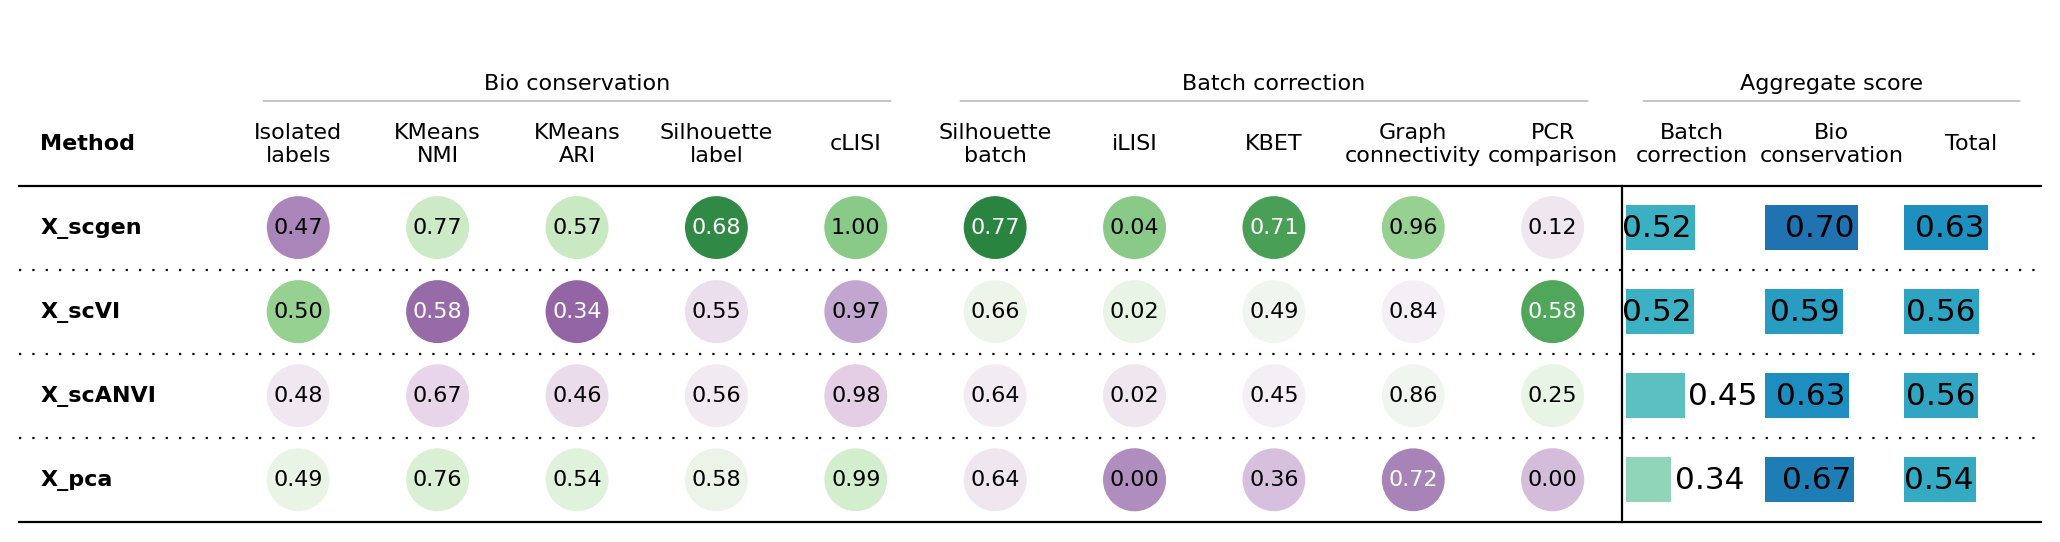

In [34]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="ct",
    embedding_obsm_keys=["X_pca", "X_scVI", "X_scANVI", "X_scgen"],
    n_jobs=-1,
)
bm.benchmark()
bm.plot_results_table(min_max_scale=False, save_dir='../results/02_mouse_integration/')

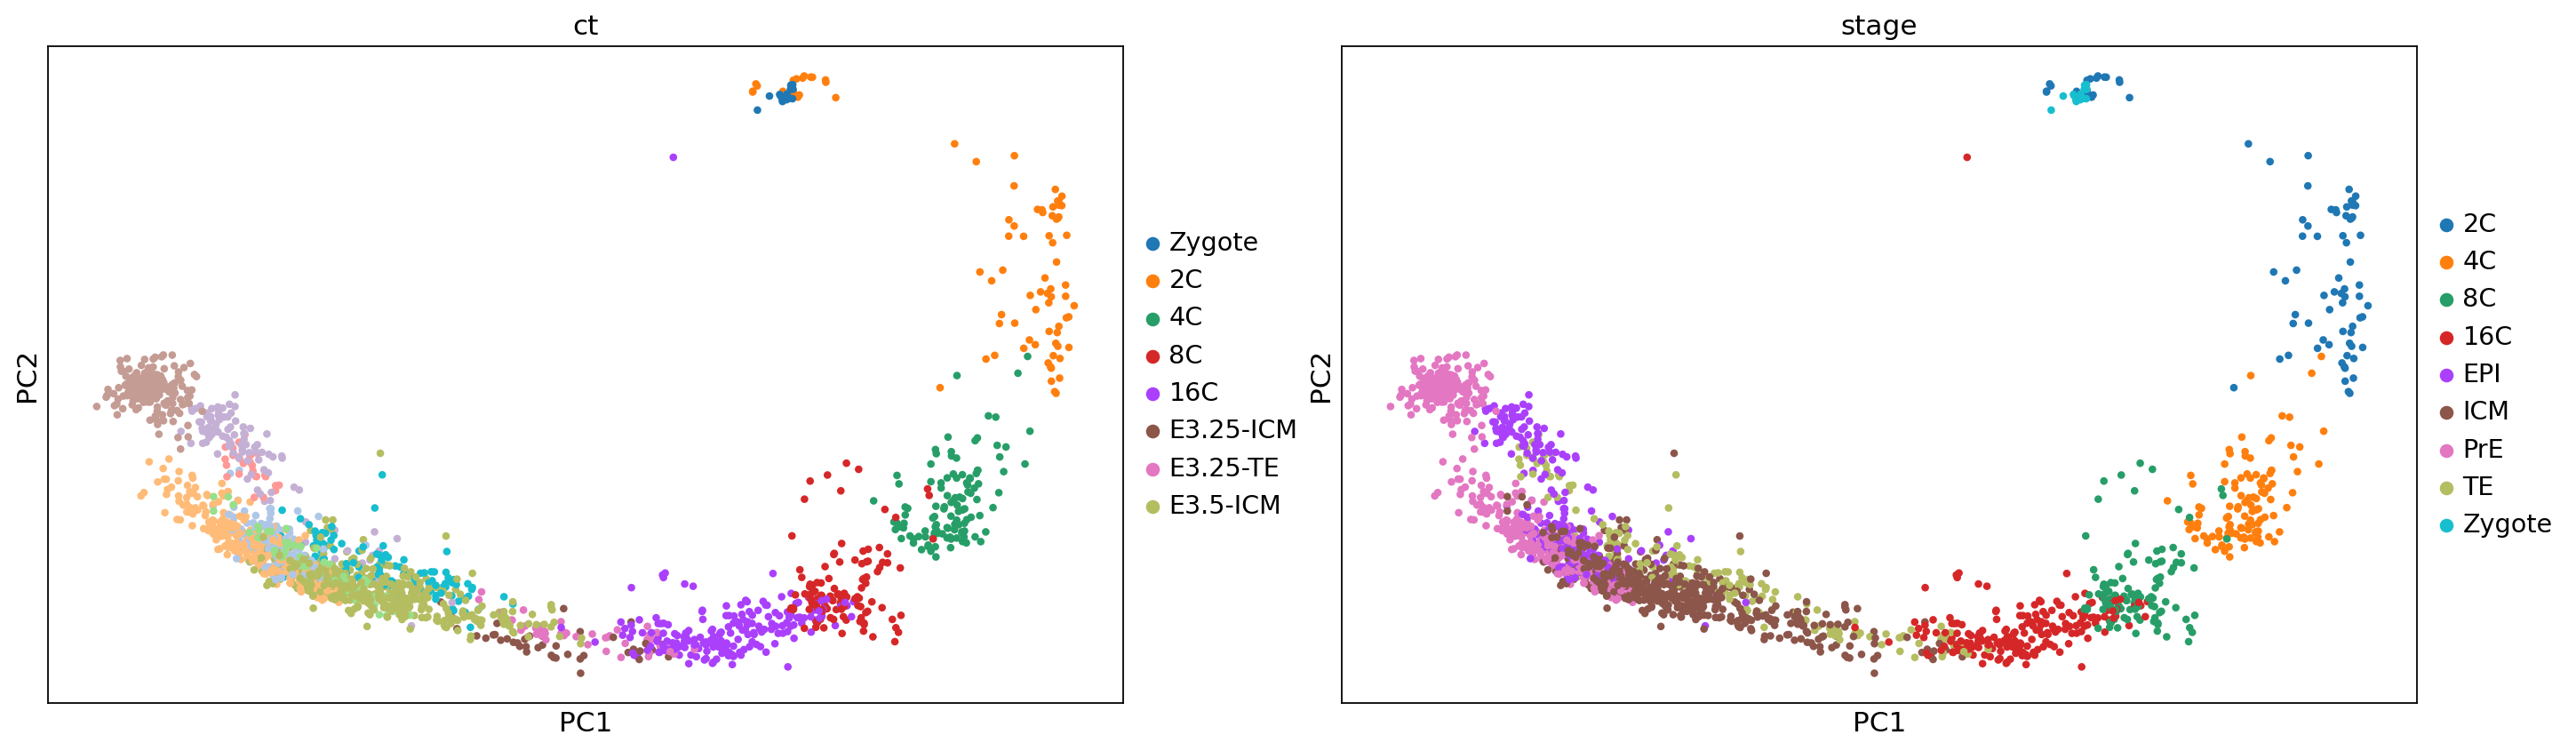

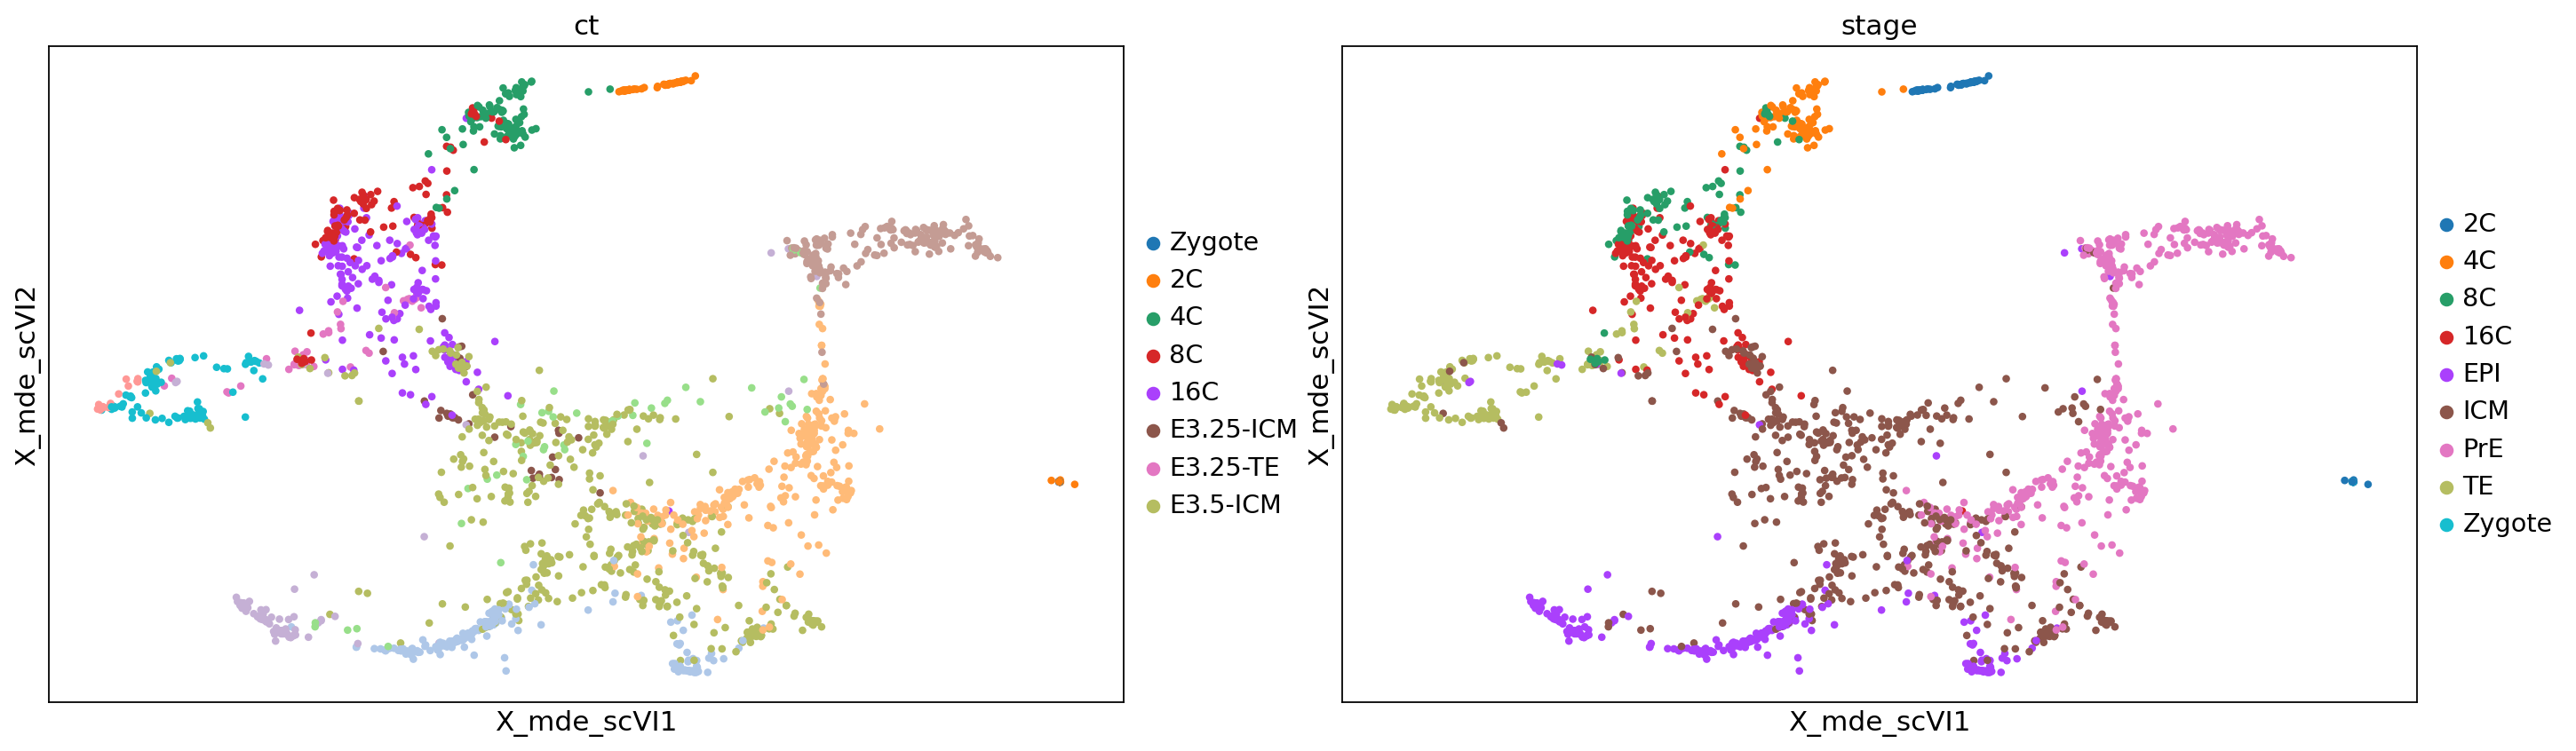

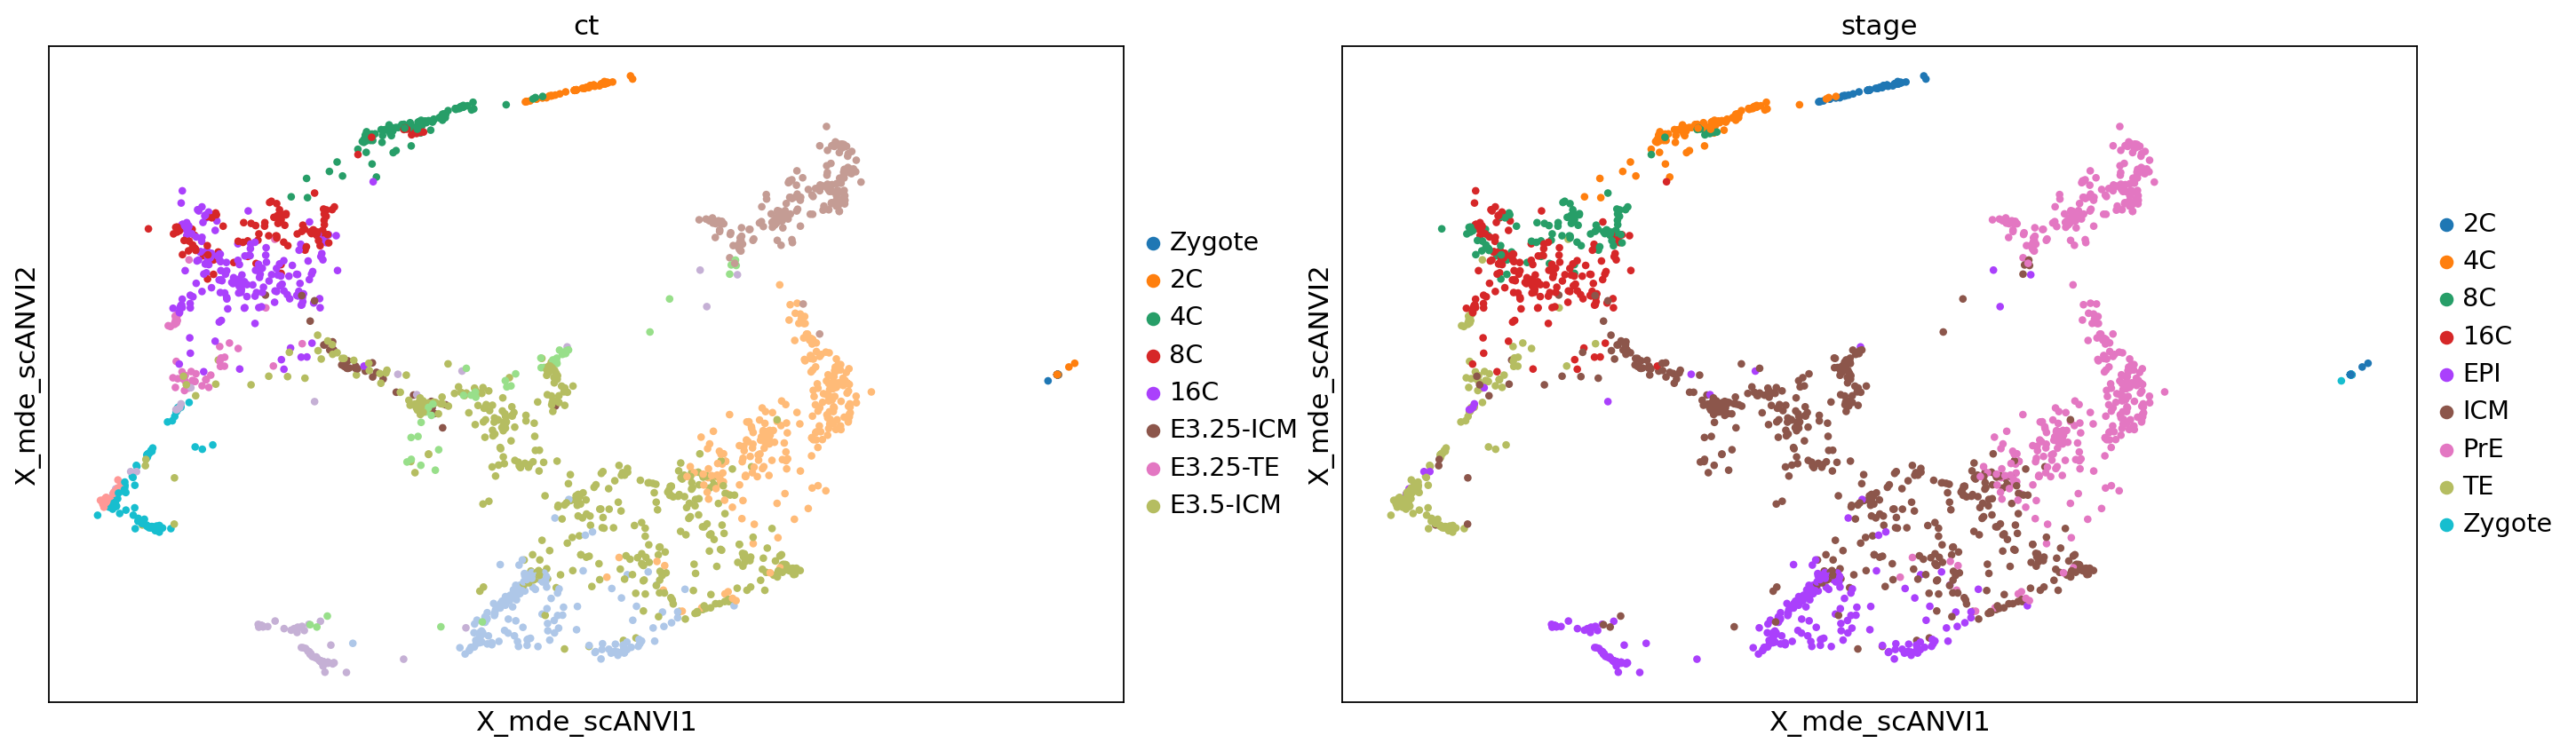

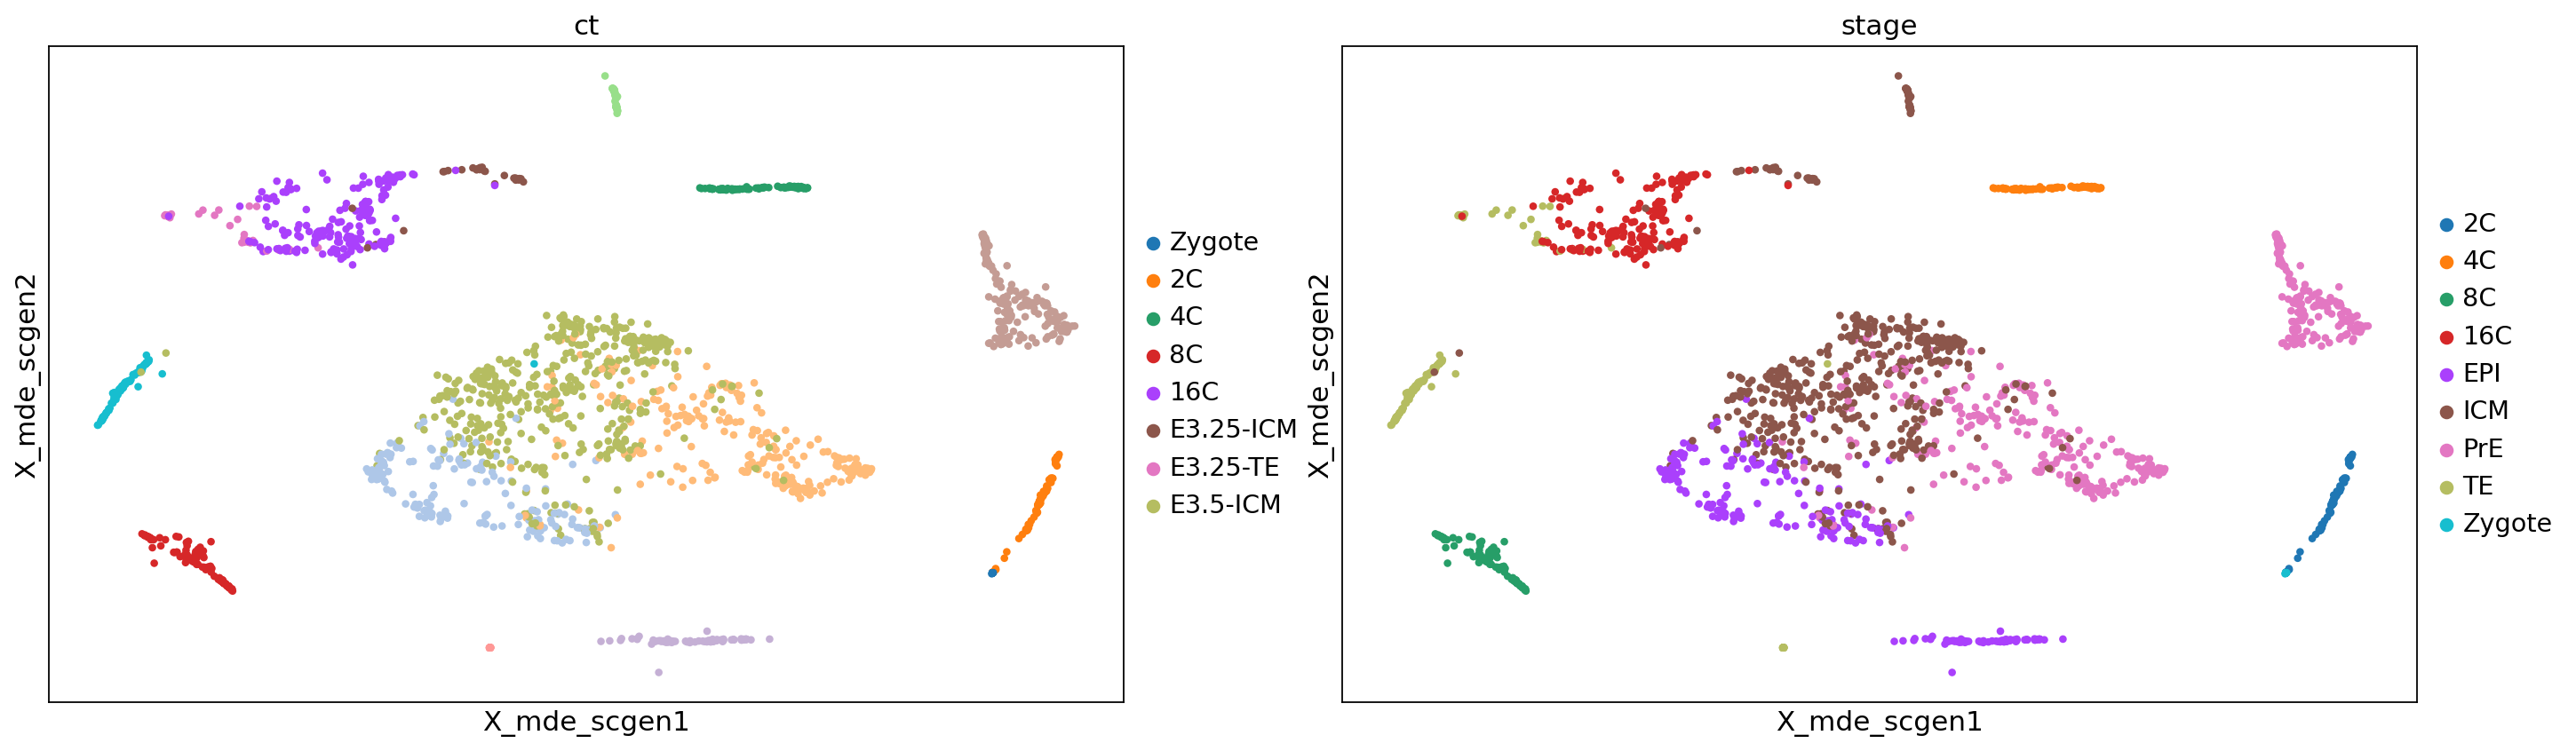

In [35]:
sc.pl.pca(adata, color=['ct', 'stage'])
sc.pl.embedding(adata, color=['ct', 'stage'], basis='X_mde_scVI')
sc.pl.embedding(adata, color=['ct', 'stage'], basis='X_mde_scANVI')
sc.pl.embedding(adata, color=['ct', 'stage'], basis='X_mde_scgen')